In [2]:
# ---------------------------------------------------------------- #
# ----------- CODE DESCRIPTION FOR ADD_DP04.py ------------------- #
# ---------------------------------------------------------------- #
# Add the important contents of the main product files to the base #
# h5 including stuff

import os
import netCDF4 as nc
import numpy as np
import h5py
import datetime
import rasterio
from scipy import optimize
import subprocess

# ------------------------- #
# USER INPUTS AND CONSTANTS #
# ------------------------- #
neon_dir = '/home/tsw35/soteria/data/NEON/dp04/'
base_dir = '/home/tsw35/soteria/data/eddy_v2/lst/'

outvar = {'DUDZ':[],'DCO2DZ':[],'DQDZ':[],'DTDZ':[],'CO2FX':[],'CO2':[]}

units = {'DUDZ':'m s-1 m-1','DCO2DZ':'μmol mol-1 m-1','DVDZ':'m s-1 m-1',\
         'DQDZ':'mmolH2O mol-1 m-1','DTDZ':'deg C m-1','CO2':'μmol mol-1',\
         'CO2FX':'μmol m-2 s-1'}

desc = {}

In [3]:
# -------------- #
# MAIN CODE LOOP #
# -------------- #
sites=os.listdir(neon_dir)
sites=['ABBY']
for site in sites:
     if len(site)>4:
          continue
     print(site+': ',end='',flush=True)
     # dictionary for storing data before loading to h5
     ovar=outvar.copy()
     for k in ovar.keys():
          ovar[k]=[]

     # Identify the base filename
     site_files=os.listdir(neon_dir+site)
     dp04_base=site_files[0][0:33]

     # Load in the base file
     fp_out=h5py.File(base_dir+site+'_L2.h5','r+')
     time=fp_out['TIME'][:]

     # Initialize site-level constants
     site_cnst={'lat':0,'lon':0,'elev':0,'zd':0,'towH':0,'canH':0}
     lat =0
     lon =0
     elev=0
     zd  =0
     z0  =0
     towH=0
     canH=0
     utc_off=0
     numlvls=0
     heights=0

     # ----------------- #
     # LOOP THROUGH TIME #
     # ----------------- #
     old_month=0
     for tf in range(len(time)):
          t=time[tf]
          tdt=datetime.datetime.fromtimestamp(t, datetime.timezone.utc)
          if tdt.month!=old_month:
               # Check to see if file exists for this month
               old_month=tdt.month
               try:
                    fp_in=h5py.File(neon_dir+site+'/'+dp04_base+\
                      str(tdt.year)+'-'+f'{tdt.month:02}'+'.basic.h5','r')
                    _load=True
                    print('.',end='',flush=True)
               except Exception:
                    _load=False
                    dp04_times=[]
                    print("'",end='',flush=True)
          else:
               _load=False
          if _load:
               # ----------------------- #
               # LOAD IN DP04 MONTH FILE #
               # ----------------------- #
               for i in range(10):
                    try:
                         th=str(i)
                         fp_in['/'+site+'/dp01/data/soni/000_0'+th+\
                                '0_30m/tempSoni/']['timeBgn'][:]
                         break;
                    except:
                         pass
               tst=fp_in['/'+site+'/dp01/data/soni/000_0'+th+\
                           '0_30m/tempSoni/']['timeBgn'][:]

               # Create an array of timestamps
               dp04_times=[]
               for ts in tst:
                    dt = datetime.datetime(int(ts[0:4]),int(ts[5:7]),\
                          int(ts[8:10]),int(ts[11:13]),int(ts[14:16]))
                    dp04_times.append(dt.replace\
                          (tzinfo=datetime.timezone.utc).timestamp())

               # load in other arrays of interest
               CO2= fp_in['/'+site+'/dp01/data/co2Turb/000_0'+th+\
                            '0_30m/rtioMoleDryCo2']['mean'][:]
               CO2FX=fp_in['/'+site+'/dp04/data/fluxCo2/turb']['flux'][:]

               # Load in Constants
               if lat==0:
                    try: lat=float(fp_in[site].attrs['LatTow'][0])
                    except Exception:pass
               if lon==0:
                    try: lon=float(fp_in[site].attrs['LonTow'][0])
                    except Exception:pass
               if elev==0:
                    try: elev=float(fp_in[site].attrs['ElevRefeTow'][0])
                    except Exception:pass
               if zd==0:
                    try: zd=float(fp_in[site].attrs['DistZaxsDisp'][0])
                    except Exception:pass
               if z0==0:
                    try: z0=np.nanmedian(fp_in[site+'/dp04/data/foot/stat']['distZaxsRgh'][:])
                    except Exception as e:print(e)
               if towH==0:
                    try: towH=float(fp_in[site].attrs['DistZaxsTow'][0])
                    except Exception:pass
               if canH==0:
                    try: canH=float(fp_in[site].attrs['DistZaxsCnpy'][0])
                    except Exception:pass
               if utc_off ==0:
                    timezones={'MST':-7,'PST/MST':-7.5,'PST':-8,'EST':-5,
                                 'CST':-6,'AKST':-9,'AST':-4}
                    tz_site = str(fp_in[site].attrs['ZoneTime'][0])[2:-1]
                    utc_off = timezones[tz_site]
               if numlvls==0:
                    try:
                        fp_in[site].attrs['DistZaxsLvlMeasTow'][0]
                        heights=np.array(fp_in[site].attrs['DistZaxsLvlMeasTow'][:],dtype='float')
                        numlvls=len(heights)
                    except Exception as e:print(e)
               if numlvls==0:
                    pass
               else:
                    nn=len(CO2)
                    Tp=np.zeros((nn,numlvls))
                    C2p=np.zeros((nn,numlvls))
                    Qp=np.zeros((nn,numlvls))
                    UPs=np.zeros((len(time),numlvls))
                    for j in range(len(heights)):
                        if j==(numlvls-1):
                            Tp[:,j]=fp_in[site+'/dp01/data/tempAirTop/000_0'+str(j+1)+'0_30m/temp']['mean'][:]
                            uu=fp_in[site+'/dp01/data/soni/000_0'+str(j+1)+'0_30m/veloXaxsErth']['mean'][:]
                            vv=fp_in[site+'/dp01/data/soni/000_0'+str(j+1)+'0_30m/veloYaxsErth']['mean'][:]

                            UPs[tf:tf+nn,j]=np.sqrt(uu**2+vv**2)
                        else:
                            Tp[:,j]=fp_in[site+'/dp01/data/tempAirLvl/000_0'+str(j+1)+'0_30m/temp']['mean'][:]
                            try:
                                UPs[:,j]=fp_out['vertical_wind/WIND_'+"{:.2f}".format(heights[j])][:]
                            except Exception as e:
                                try:
                                    UPs[:,j]=fp_out['vertical_wind/WIND_'+str(heights[j])][:]
                                except Exception as e:
                                    print(e)
          # --------------------- #
          # PERFORM EACH TIMESTEP #
          # --------------------- #
          #vertical profiles

          #get dp04 index
          a=np.where(dp04_times[:]==t)[0]
          if len(a)==0:
               # if this time is not present in dp04 or file does not
               # exist, we fill with empty
               for var in ovar.keys():
                    ovar[var].append(-9999)
               continue
          else:
               index=a[0]

          # now that we have an index, load all the data
          ovar['CO2'].append(CO2[index])
          ovar['CO2FX'].append(CO2FX[index])

          Up=UPs[tf,:]

          # Compute gradients
          def intT(z_,a,b,c):
               return a+b*(z_-zd)+c*np.log(z_-zd)

          def intU(z_,b,c):
               a=-c*np.log(z0)
               return a+b*z_+c*np.log(z_)
          def intU(z_,a,b,c):
               return a+b*(z_-zd)+c*np.log(z_-zd)

          try:
               hzdp=np.argmax((np.array(heights)-zd)>0)
               bcd,out=optimize.curve_fit(intT,heights[hzdp:],Tp[index,hzdp:])
               zs=np.linspace(heights[-1]-.5,heights[-1]+.5,11)
               outs=intT(zs,bcd[0],bcd[1],bcd[2])
               DTDZ=np.gradient(outs,zs)[5]
          except Exception as e:
               DTDZ=-9999


          try:
               if np.sum(Up<=0)>0:
                    DUDZ=-9999
               else:
                    hzdp=np.argmax((np.array(heights)-zd)>0)
                    bcd,out=optimize.curve_fit(intU,heights[hzdp:],Up[hzdp:])
                    zs=np.linspace(heights[-1]-.5,heights[-1]+.5,11)
                    outs=intU(zs,bcd[0],bcd[1],bcd[2])
                    DUDZ=np.gradient(outs,zs)[5]
          except Exception as e:
               DUDZ=-9999

          # load the data into output
          #ovar['DCO2DZ'].append(DCO2DZ[index])
          #ovar['DQDZ'].append(DQDZ[index])
          ovar['DTDZ'].append(DTDZ)
          ovar['DUDZ'].append(DUDZ)


ABBY: ''''''''''.......'................................................

In [29]:
fp_out.close()

In [6]:
mm=np.ones((96336,),dtype='bool')
for i in range(5):
    mm=mm&(UPs[:,i]>-999)

In [12]:
dudz=np.array(ovar['DUDZ'][:])

In [13]:
np.median(dudz[dudz>-9999])

-0.004380181625416313

In [19]:
np.sum((dudz>-9999))

30817

In [25]:
np.sum((dudz>-9999)&(np.abs(dudz)>0))

30817

In [16]:
h5dump -h 

NameError: name 'plt' is not defined

In [17]:
import matplotlib.pyplot as plt

(array([1.000e+00, 2.000e+00, 8.000e+00, 4.000e+00, 4.000e+00, 8.000e+00,
        9.000e+00, 3.000e+00, 8.000e+00, 7.000e+00, 3.000e+00, 9.000e+00,
        2.100e+01, 3.000e+01, 4.800e+01, 6.100e+01, 9.300e+01, 1.370e+02,
        2.190e+02, 2.840e+02, 4.990e+02, 8.710e+02, 2.502e+03, 6.812e+03,
        9.270e+03, 5.100e+03, 1.633e+03, 8.280e+02, 6.440e+02, 4.910e+02,
        3.320e+02, 2.100e+02, 1.380e+02, 8.800e+01, 7.700e+01, 6.000e+01,
        5.000e+01, 3.100e+01, 2.100e+01, 2.700e+01, 2.100e+01, 2.500e+01,
        1.700e+01, 1.600e+01, 1.400e+01, 1.300e+01, 9.000e+00, 1.300e+01,
        4.000e+00]),
 array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
        -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
         0.02040816,  

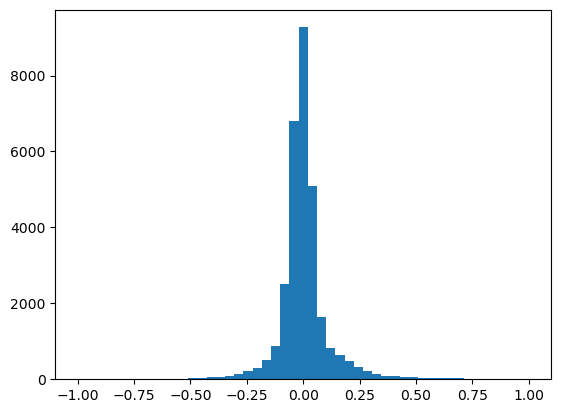

In [26]:
plt.hist(dudz[dudz>-9999],bins=np.linspace(-1,1))

-9999